### 개미 이미지와 벌 이미지 분류하는 hymenoptera_data(kaggle)

In [1]:
#이미지 불러올때 커널 죽는거 방지 코드  
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
''' 1. module import'''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
''' 2. 딥러닝 모델을설계할 때 활용하는 장비 확인'''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)
# Using PyTorch version: 1.4.0 Device: cuda => GPU 이용

Using PyTorch version: 1.5.0+cu92 Device: cuda


In [4]:
BATCH_SIZE = 32 
EPOCHS = 10

In [5]:
import os
print(os.getcwd())

C:\Users\leeej\practice_DL


In [6]:
''' 3. 개미와 벌을 분류하기 위해 개미 이미지데이터와 벌 이미지데이터 불러오기(train, test set 분리)'''
data_transforms = {
    'train': transforms.Compose([ #transforms.Compose : 이미지데이터 전처리, Augmentation다양하게 적용하는 메서드
        transforms.RandomResizedCrop(224), #변경되는 이미지 픽셀 값은 랜덤으로 선택해 224사이즈로 변경
        transforms.RandomHorizontalFlip(), #해당 이미지를 50%확률로 좌우 반전
        transforms.ToTensor(), #0~1사이의 값으로 정규화, 딥러닝 모델의 input으로 이용되도록 tensor형태로 변환시켜주는 전처리
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])#totensor 형태로 전환된 이미지에 대해 또 다른 정규화 진행.
        #[r,g,b]순으로 평균, 표준편차를 0.5씩 적용
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),#해당 이미지 중앙을 기준으로 224*224크기로 이미지 잘라내어 사이즈 변경
        transforms.Resize(256),#해당 이미지를 256*256크기로 변경
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

#data_dir="../data/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder("../data/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
                                          #해당 root로 접근해 train, val폴더에 접근해 데이터 불러오기
                                          #기존에 정의한 data_transforms의 학습 데이터셋에 이용되는 전처리과정, 
                                          #검증데이터셋에 이용되는 전처리 과정을 각각 적용
                                          
#위의 경로에서 불러온 이미지를 미니배치단위로 구분하기 위해 dataloder함수 이용
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],#학습데이터셋, 검증데이터셋에 각각 적용하기 위해 dic구조 사용
                                              batch_size = BATCH_SIZE,
                                              num_workers = 0,
                                              #학습데이터셋, 검증데이터셋을 각각 진행한 결과는 dic에 저장하며 데이터 순서 섞음
                                              shuffle = True) for x in ['train', 'val']}

In [7]:
''' 4. 데이터 확인(1)'''
for (x_train, y_train) in dataloaders['train']:
    print('x_train:', x_train.size(), 'type:', x_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    #print(x_train, y_train)
    break
    
# x_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
# [mini-batch, channel, height, width]

x_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

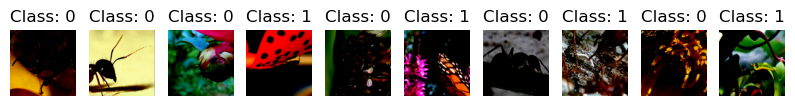

In [8]:
''' 5. 데이터 확인(2)'''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1) #(nrows,ncols,index)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i],(1,2,0)))#괄호 안의 숫자를 조정하여 사용자가 한번에 여러 축을 바꿔서 사용할 수 있는 기능
    #([1],[2],[0])차원으로 바꿔라 
    # => torch.Size([32, 3, 224, 224])에서 사람의 눈으로 직접 확인할 수 있도록[224, 224, 3]로 transpose
    plt.title('Class: ' + str(y_train[i].item()))

In [9]:
x_train.shape
# torch.Size([32, 3, 224, 224]) : [mini-batch, channel, height, width]

torch.Size([32, 3, 224, 224])

In [10]:
tr = np.transpose(x_train[i],(1,2,0))

In [11]:
tr.shape

torch.Size([224, 224, 3])

In [12]:
''' 6. 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의'''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx,(image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        # 과거에 이용한 미니배치 내에 있는 이미지데이터와 레이블데이터를 바탕으로 계산된 Loss의 Gradient값이 
        # optimizer에 할당돼 있으므로 optimizer의 gradient를 초기화
        optimizer.zero_grad()
        output = model(image) 
        #len(output):32
        #print(output.shape) : torch.Size([32, 2])
        print(output)
        '''[[ 0.2289, -0.5370],
        [-0.1494, -0.1537],
        [ 0.3236, -0.2995],
        [-0.1419, -0.1963],
        [ 1.3066, -1.7476],
        [ 0.3377, -0.6730],
        [ 0.0567, -0.1660],
        [ 0.7221, -1.4151],
        [ 0.0760, -0.3191],
        [ 0.4986, -0.7762],
        [ 0.6011, -0.9285],
        [ 0.1928, -0.6632],
        [ 0.7955, -0.9926],
        [-0.0732, -0.2053],
        [ 0.4641, -0.6421],
        [-0.0842, -0.7166],
        [ 0.0206, -0.3295],
        [ 0.1738, -0.1395],
        [ 0.0864, -0.2045],
        [ 0.0722, -0.1599],
        [-0.1667, -0.1439],
        [ 0.3554, -0.5539],
        [-0.0254, -0.2044],
        [ 0.2933, -0.8335],
        [ 0.1433, -0.4600],
        [ 0.3596, -0.5777],
        [ 0.6725, -0.9210],
        [ 0.2214, -0.6477],
        [ 0.9218, -1.4560],
        [ 0.0447, -0.5088],
        [-0.0269, -0.2037],
        [-0.0720, -0.4845]]'''
        loss = criterion(output, label)
        
        #loss값을 계산한 결과를 바탕으로 역전파를 이용해 계산된 gradient값을 각 파라미터에 할당
        loss.backward()
        
        #각 파라미터에 할당된 gradient값을 이용해 파라미터값 업데이트
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))

In [13]:
len(dataloaders['train'])

13

In [14]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의'''
def evaluate(model, test_loader):
    model.eval()
    #기존에 정의한 test_loader내의 데이터를 이용해 loss값을 계산하기 위해 test_loss를 0으로 임시설정
    test_loss=0
    correct=0
    
    #모델 평가단계에서 gradient를 통해 파라미터 값이 업데이트 되는 현상을 방지하기 위해 torch.no_grad()메서드 이용해 gradient흐름 억제
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            #계산된 output과 레이블데이터를 crossentropy를 이용해 loss값을 계산한 결괏값을 test_loss에 더해 업데이트
            test_loss += criterion(output, label).item()
            
            #output값은 크기가 10인 벡터 값. 계산된 벡터 값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단.
            prediction = output.max(1, keepdim = True)[1]
            
            #모델이 최종으로 예측한 클래스의 값(prediction)과 실제 레이블(label)이 의미하는 클래스가 맞으면 correct에 더해 올바르게 예측한 횟수 저장
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    #현재까지 계산된 test_loss값을 test_loader내에 존재하는 미니배치 개수만큼 나눠 평균 loss값으로 계산
    test_loss /= len(test_loader.dataset)
    
    #test_loader데이터 중 얼마나 맞췄는지를 계산해 정확도를 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) #len(test_loader.dataset):10000
    return test_loss, test_accuracy

In [15]:
''' 8. 파이토치 내에서 제공하는 미리 학습되지 않은 ResNet18모델 불러온 후 Output크기 설정'''
import torchvision.models as models
#resnet18모델 불러옴. 모델의 구조만 불러오고, 모델 구조 내에 있는 파라미터는 특정 initializer에서 랜덤 샘플링한 값을 이용해 모델 불러오기
model = models.resnet18(pretrained = False).cuda()
#resnet18모델에 대해 fc layer구성하는 부분에 접근. in_features:모델의 fc layer의 input에 해당하는 노드 수를 num_ftrs로 저장
num_ftrs = model.fc.in_features
#모델의 fc layer의 input에 해당하는 노드수를 이용해 새로운 레이어 추가
#image net데이터의 클래스는 1000개이기 때문에 최종 output의 노드수는 1000개로 설정돼있지만, 
#개미, 벌 이미지를 분류하기때문에 최종 output의 노드수를 2개로 설정
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda() #model.to(DEVICE)

'''9. Optimizer, Object Function 설정'''
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
''' 10. 미리 학습되지 않은 ResNet18학습을 실행하며 train, test set의 loss 및 test set accuracy확인'''
for Epoch in range(1, EPOCHS+1):
    train(model, dataloaders["train"], optimizer, log_interval=5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f}%\n".format(
    Epoch, test_loss, test_accuracy))

tensor([[-0.4996,  0.2449],
        [-0.5037,  0.4159],
        [-0.3535,  0.0931],
        [-0.6734,  0.1152],
        [-0.3973,  0.0924],
        [-0.6238,  0.1046],
        [-0.4649,  0.1668],
        [-0.5611, -0.0054],
        [-0.5627,  0.3410],
        [-0.5242,  0.2094],
        [-0.4644,  0.1621],
        [-0.2002,  0.1273],
        [-0.3562,  0.3075],
        [-0.4938,  0.4059],
        [-0.5266,  0.2110],
        [-0.7208,  0.2977],
        [-0.4973,  0.2250],
        [-0.2722,  0.1839],
        [-0.5903,  0.1975],
        [-0.6231,  0.3342],
        [-0.7963,  0.1008],
        [-0.5937,  0.2349],
        [-0.6830,  0.1105],
        [-0.4965,  0.1371],
        [-0.4560,  0.4498],
        [-0.6070,  0.1596],
        [-0.7185,  0.2823],
        [-0.3536,  0.1795],
        [-0.5070,  0.1658],
        [-0.9918, -0.1581],
        [-0.4952,  0.2823],
        [-0.3726,  0.3187]], device='cuda:0', grad_fn=<AddmmBackward>)
Train Epoch: 1 [0/397(0%)]	Train Loss: 0.870076
tensor([[-4.2

tensor([[ 0.0812, -0.5067],
        [ 0.4042, -0.5762],
        [ 0.2021, -0.5001],
        [ 0.0993, -0.2723],
        [-0.0257, -0.6173],
        [ 0.1788, -0.4564],
        [ 0.3267, -0.5818],
        [ 0.4653, -0.6332],
        [-0.1537, -0.3098],
        [ 0.2666, -0.4361],
        [ 0.0527, -0.4064],
        [ 0.0644, -0.0229],
        [ 0.4591, -0.9588],
        [ 0.1776, -0.6051],
        [ 0.5236, -0.7739],
        [ 0.1720, -0.3624],
        [-0.0807, -0.3917],
        [ 0.3642, -0.4532],
        [ 0.1570, -0.2120],
        [-0.0451, -0.4539],
        [ 0.2128, -0.5691],
        [ 0.1273, -0.2099],
        [ 0.3370, -0.8624],
        [-0.1311, -0.1232],
        [-0.0369, -0.3767],
        [ 0.4117, -0.7573],
        [ 0.1763, -0.5777],
        [-0.0691, -0.3900],
        [-0.0030, -0.2167],
        [ 0.2286, -0.4814],
        [ 0.4307, -0.3078],
        [-0.0509, -0.5829]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.3360, -0.8184],
        [ 0.3416, -0.4452],
     

Train Epoch: 2 [160/397(38%)]	Train Loss: 0.692131
tensor([[ 0.2127, -0.4183],
        [ 0.1789, -0.2428],
        [-0.1847, -0.2618],
        [ 0.5347, -0.7680],
        [-0.3338, -0.2448],
        [ 0.7449, -0.7341],
        [ 1.0000, -0.9862],
        [ 0.4593, -0.6918],
        [ 0.3674, -0.4688],
        [ 0.2612, -0.6124],
        [-0.1412, -0.3877],
        [ 0.5478, -0.7561],
        [ 0.7083, -0.7528],
        [-1.3130,  0.1424],
        [-0.0776, -0.2949],
        [ 0.1045, -0.3703],
        [-0.2275, -0.3443],
        [-0.7395, -0.0318],
        [-0.5844, -0.3565],
        [ 0.1622, -0.2930],
        [ 0.7905, -0.7052],
        [ 0.0526, -0.3895],
        [ 0.2427, -0.7477],
        [ 0.3248, -0.5556],
        [ 0.0255, -0.2535],
        [ 0.0400, -0.3042],
        [ 0.4660, -0.6513],
        [ 0.1715, -0.3755],
        [ 0.4692, -0.5700],
        [ 0.0038, -0.4371],
        [ 0.3411, -0.3393],
        [ 0.4165, -0.5734]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 

tensor([[ 0.1506, -0.3451],
        [-0.8801,  0.3417],
        [ 0.3145, -0.4310],
        [ 0.4141, -0.6982],
        [ 0.4194, -0.4754],
        [ 0.2357, -0.4279],
        [ 0.4560, -0.6945],
        [ 0.5104, -0.7253],
        [-0.1814, -0.1340],
        [-2.4725,  1.1894],
        [ 0.3511, -0.2598],
        [ 0.2543, -0.4622],
        [ 0.2980, -0.5556],
        [-0.3439,  0.1247],
        [ 0.2885, -0.5778],
        [ 0.2432, -0.5325],
        [ 0.0177, -0.3467],
        [ 0.4198, -0.6898],
        [ 0.4653, -0.5783],
        [ 0.1252, -0.4260],
        [-0.3707, -0.3630],
        [ 0.2464, -0.5910],
        [-0.5444, -0.1211],
        [ 0.1021, -0.3549],
        [ 0.0973, -0.3625],
        [ 0.0156, -0.5088],
        [-0.8854,  0.3682],
        [ 0.2792, -0.5977],
        [-0.0771, -0.3249],
        [ 0.2990, -0.5706],
        [ 0.4468, -0.5379],
        [ 0.3025, -0.4409]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-5.7480e-01, -1.1524e-01],
        [ 1.7771e-01, -5.

Train Epoch: 3 [320/397(77%)]	Train Loss: 0.695292
tensor([[-0.1112, -0.5583],
        [-0.5056,  0.4183],
        [-0.1204, -0.1935],
        [ 0.0496, -0.0538],
        [ 0.1598, -0.1930],
        [ 0.0156, -0.5530],
        [-0.5772,  0.3354],
        [-0.2340,  0.0379],
        [ 0.5644, -0.9845],
        [ 0.3033, -0.7919],
        [ 0.8622, -1.5258],
        [ 0.1260, -0.1573],
        [-0.3098,  0.1771],
        [-0.7439,  0.7120],
        [-0.4585,  0.3895],
        [ 0.2842, -0.4395],
        [ 0.2269, -0.4425],
        [ 0.1621, -0.3376],
        [ 0.2609, -0.6235],
        [ 0.9353, -1.5003],
        [-0.0080, -0.2424],
        [-0.2002, -0.0409],
        [ 0.4280, -0.8881],
        [-0.6001,  0.3338],
        [ 0.1982, -0.5272],
        [-0.2417, -0.1356],
        [ 0.4631, -0.9015],
        [-0.0919, -0.2979],
        [ 0.0640, -0.3085],
        [ 0.1671, -0.6432],
        [ 0.2745, -0.7647],
        [-0.0742, -0.2648]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 

tensor([[ 0.1206, -0.3401],
        [ 0.1052, -0.3240],
        [ 1.0631, -1.3955],
        [-0.0467, -0.1425],
        [ 0.5362, -0.8159],
        [ 0.2772, -0.5958],
        [ 0.3258, -0.7444],
        [ 0.1220, -0.4270],
        [ 0.2159, -0.6997],
        [ 0.3636, -0.8271],
        [ 0.0665, -0.4115],
        [ 0.3427, -0.6382],
        [-0.0533, -0.1902],
        [ 0.0465, -0.2850],
        [-1.0687,  0.7719],
        [ 0.2018, -0.4535],
        [ 0.1097, -0.3222],
        [ 0.2319, -0.4317],
        [-0.0474, -0.2512],
        [ 0.2824, -0.6420],
        [ 0.4388, -0.6008],
        [ 0.1646, -0.4024],
        [-0.0894, -0.3341],
        [-0.0723, -0.5940],
        [ 0.3127, -0.5801],
        [ 0.0374, -0.3091],
        [ 0.0793, -0.2757],
        [ 0.8093, -0.9627],
        [ 0.2271, -0.6020],
        [ 0.0217, -0.1379],
        [-0.0816, -0.1207],
        [ 0.0720, -0.5558]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.1160, -0.2594],
        [ 0.1831, -0.3331],
     

KeyboardInterrupt: 

In [27]:
''' 11. ImageNet 데이터로 학습된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine Tuning 해보기'''
#resnet18모델 불러옴. ImageNet 데이터를 잘 분류할 수 있도록 학습된 파라미터를 모델에 적용
model = models.resnet18(pretrained = True)
#resnet34모델에 대해 fc layer구성하는 부분에 접근. in_features :모델의 fc layer의 input에 해당하는 노드 수를 num_ftrs로 저장
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda() #model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
EPOCHS = 10
for Epoch in range(1, EPOCHS+1):
    train(model, dataloaders["train"], optimizer, log_interval=5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f}%\n".format(
    Epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397(0%)]	Train Loss: 0.669683
Train Epoch: 1 [160/397(38%)]	Train Loss: 0.756412
Train Epoch: 1 [320/397(77%)]	Train Loss: 0.701919

[EPOCH: 1], 	Test Loss: 0.0212, 	Test Accuracy: 63.73%

Train Epoch: 2 [0/397(0%)]	Train Loss: 0.623271
Train Epoch: 2 [160/397(38%)]	Train Loss: 0.627539
Train Epoch: 2 [320/397(77%)]	Train Loss: 0.577788

[EPOCH: 2], 	Test Loss: 0.0167, 	Test Accuracy: 75.31%

Train Epoch: 3 [0/397(0%)]	Train Loss: 0.461396
Train Epoch: 3 [160/397(38%)]	Train Loss: 0.450317
Train Epoch: 3 [320/397(77%)]	Train Loss: 0.390987

[EPOCH: 3], 	Test Loss: 0.0140, 	Test Accuracy: 79.35%

Train Epoch: 4 [0/397(0%)]	Train Loss: 0.468515
Train Epoch: 4 [160/397(38%)]	Train Loss: 0.364685
Train Epoch: 4 [320/397(77%)]	Train Loss: 0.588484

[EPOCH: 4], 	Test Loss: 0.0120, 	Test Accuracy: 87.15%

Train Epoch: 5 [0/397(0%)]	Train Loss: 0.356646
Train Epoch: 5 [160/397(38%)]	Train Loss: 0.342721
Train Epoch: 5 [320/397(77%)]	Train Loss: 0.300062

[EPOCH: 5], 	Test Los